In [1]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm

sys.path.insert(0,'..')
import pyathena as pa

### The following illustrates how one can use child classes to make Athena data analysis easier and faster. We will take the `feedback_test` problem as an example.


- The scripts (e.g., `feedback_test/load_sim_feedback_test.py`) are included in the pyathena package but they can reside anywhere.


- We first define a child class of LoadSim (`LoadSimFeedbackTest` in this case). Note that it inherits the `read_hst` method from the `ReadHst` class, which is written in a separate file `read_hst.py` (see below). Similarly, you can add other methods from other files to the LoadSim class.


- We also define `LoadSimFeedbackTestAll` class to be able to analyze multiple simulation datasets.

In [ ]:
# %load ../pyathena/feedback_test/load_sim_feedback_test.py

import os
import pandas as pd

from ..load_sim import LoadSim
from ..util.units import Units

from .read_hst import ReadHst

class LoadSimFeedbackTest(LoadSim, ReadHst):
    """LoadSim class for analyzing LoadSimFeedbackTest simulations.
    """
    
    def __init__(self, basedir, savdir=None, load_method='pyathena',
                 units=Units(kind='LV', muH=1.4271),
                 verbose=False):
        """The constructor for LoadSimFeedbackTest class

        Parameters
        ----------
        basedir : str
            Name of the directory where all data is stored
        savdir : str
            Name of the directory where pickled data and figures will be saved.
            Default value is basedir.
        load_method : str
            Load vtk using 'pyathena' or 'yt'. Default value is 'pyathena'.
            If None, savdir=basedir. Default value is None.
        verbose : bool or str or int
            Print verbose messages using logger. If True/False, set logger
            level to 'DEBUG'/'WARNING'. If string, it should be one of the string
            representation of python logging package:
            ('NOTSET', 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL')
            Numerical values from 0 ('NOTSET') to 50 ('CRITICAL') are also
            accepted.
        """

        super(LoadSimFeedbackTest,self).__init__(basedir, savdir=savdir,
                                                 load_method=load_method,
                                                 units=units,
                                                 verbose=verbose)


class LoadSimFeedbackTestAll(object):
    """Class to load multiple simulations"""
    def __init__(self, models=None):

        # Default models
        if models is None:
            models = dict()
            models['newcool.n200.M1E3.N128'] = '/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/roe.newcool.n200.M1E3.N128'

        self.models = list(models.keys())
        self.basedirs = dict()
        
        for mdl, basedir in models.items():
            self.basedirs[mdl] = basedir

    def set_model(self, model, savdir=None, load_method='pyathena', verbose=False):
        
        self.model = model
        self.sim = LoadSimFeedbackTest(self.basedirs[model], savdir=savdir,
                                       load_method=load_method, verbose=verbose)
        return self.sim


### ReadHst class is defined in the read_hst.py script. There we read the history dump file (`.hst` file), convert raw data into convenient units , and calculate derived quantities.

* The decorator `LoadSim.Decorators.check_pickle_hst` is used to pickle the output so that we don't have to do the conversion every time we read the output. Unless the `force_override` flag is set to `True`, the conversion is done only once and the pandas DataFrame will be read afterwards.

* We have similar decorators for zprof output and any other data that can be pickled. (see decorators defined in `load_sim.py`)

In [ ]:
# %load ../pyathena/feedback_test/read_hst.py
# read_hst.py

import os
import numpy as np
import pandas as pd
import astropy.constants as ac
import astropy.units as au

from ..io.read_hst import read_hst
from ..load_sim import LoadSim

class ReadHst:

    @LoadSim.Decorators.check_pickle_hst
    def read_hst(self, savdir=None, force_override=False):
        """Function to read hst and convert quantities to convenient units
        """

        hst = read_hst(self.files['hst'], force_override=force_override)

        u = self.u
        domain = self.domain
        # volume of resolution element (code unit)
        dvol = domain['dx'].prod()
        # total volume of domain (code unit)
        vol = domain['Lx'].prod()        

        # Time in code unit
        hst['time_code'] = hst['time']
        # Time in Myr
        hst['time'] *= u.Myr
        # Time step
        hst['dt_code'] = hst['dt']
        hst['dt'] *= u.Myr
        
        # Shell formation time for a single SN in Myr
        # (Eq.7 in Kim & Ostriker 2015)
        tsf = 4.4e-2*self.par['problem']['n0']**-0.55
        hst['time_tsf'] = hst['time']/tsf
        hst['tsf'] = tsf

        # Shell formation time for wind goes here..

        
        # Total gas mass in Msun
        hst['mass'] *= vol*u.Msun

        # Mass weighted SNR position in pc
        hst['Rsh'] = hst['Rsh_den']/hst['Msh']*u.pc
        # shell mass in Msun
        hst['Msh'] *= u.Msun*vol
        # hot gas mass in Msun
        hst['Mhot'] *= u.Msun*vol
        # warm gas mass in Msun
        hst['Mwarm'] *= u.Msun*vol
        # intermediate temperature gas in Msun
        hst['Minter'] *= u.Msun*vol
        # cold gas mass in Msun
        hst['Mcold'] *= u.Msun*vol

        # Total/hot gas/shell momentum in Msun*km/s
        hst['pr'] *= vol*(u.mass*u.velocity).value
        hst['pr_hot'] *= vol*(u.mass*u.velocity).value
        hst['pr_sh'] *= vol*(u.mass*u.velocity).value

        # For radiation feedback
        if self.par['configure']['radps'] == 'ON':
            from scipy.integrate import cumtrapz

            # Expected radial momentum injection in the optically-thick limit
            hst['pr_inject'] = cumtrapz(hst['Ltot0']/ac.c.to(u.velocity).value,
                                      hst['time_code'], initial=0.0)
            hst['pr_inject'] *= vol*(u.mass*u.velocity).value

            # Total/escaping luminosity in Lsun
            try:
                for i in range(self.par['radps']['nfreq']):
                    hst[f'Ltot{i}'] *= vol*u.Lsun
                    hst[f'Lesc{i}'] *= vol*u.Lsun
            except KeyError:
                pass

        hst.index = hst['time_code']
        
        self.hst = hst
        
        return hst


###### Initialize `LoadSimAll` class with model names and basedirs

In [2]:
models = dict(N64='/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N64/',
              N128='/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N128/',
              N256='/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N256.again/')
sa = pa.LoadSimFeedbackTestAll(models)

In [3]:
sa.models # (would also be possible to define multiple subsets of models in the initialization)

['N64', 'N128', 'N256']

In [4]:
sa.basedirs

{'N64': '/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N64/',
 'N128': '/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N128/',
 'N256': '/perseus/scratch/gpfs/jk11/FEEDBACK-TEST/rad.newcool.n200.N256.again/'}

### Loop over models and plot shell radius, shell momentum, mass, shell velocity, etc.

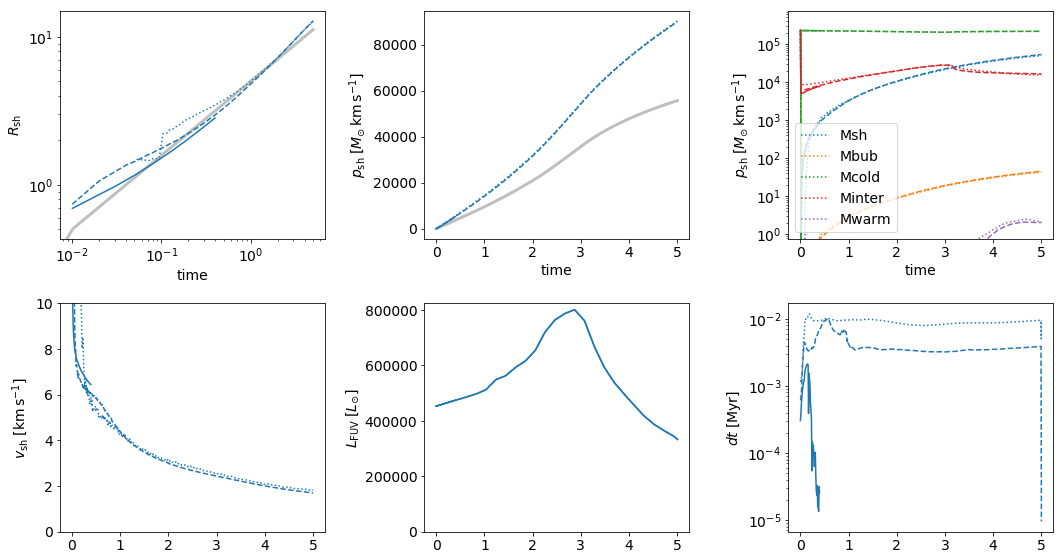

In [10]:
mpl.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

ls = [':', '--', '-']
for i, mdl in enumerate(sa.models): 
    
    s = sa.set_model(mdl)
    h = s.read_hst(force_override=True)
    t = h['time_code']
    kwargs = dict(ls=ls[i])
    plt.sca(axes[0])
    plt.loglog(t, h['Rsh'], c='C0', **kwargs)
    if i == 0:
        plt.plot(t, 5.0*t**0.5, c='grey', lw=3, alpha=0.5)
        plt.xlabel('time')
        plt.ylabel(r'$R_{\rm sh}$')

    plt.sca(axes[1])
    plt.plot(t, h['pr_sh'], c='C0', **kwargs)

    if i == 0:
        plt.plot(t, h['pr_inject'], c='grey', lw=3, alpha=0.5)
        plt.xlabel('time')
        plt.ylabel(r'$p_{\rm sh}\;[M_{\odot}\,{\rm km}\,{\rm s}^{-1}]$')

    plt.sca(axes[2])
    plt.plot(t, h['Msh'], c='C0', **kwargs)
    plt.plot(t, h['Mbub'], c='C1', **kwargs)
    plt.plot(t, h['Mcold'], c='C2', **kwargs)
    plt.plot(t, h['Minter'], c='C3', **kwargs)
    plt.plot(t, h['Mwarm'], c='C4', **kwargs)
    #plt.plot(t, h['Mhot'], c='C5', **kwargs)
    if i == 0:
        plt.yscale('log')
        plt.ylim(bottom=plt.gca().get_ylim()[1]*1e-6)
        #plt.ylim(1e-3,1)
        plt.xlabel('time')
        plt.ylabel(r'$Mass\;[M_{\odot}]$')
        plt.legend()
        
    # Shell velocity
    plt.sca(axes[3])
    plt.plot(t, h['pr_sh']/h['Msh'], c='C0', **kwargs)
    if i == 0:
        plt.ylim(0, 10)
        plt.ylabel(r'$v_{\rm sh}\;[{\rm km}\,{\rm s}^{-1}]$')

    # Luminosity
    plt.sca(axes[4])
    plt.plot(t, h['Ltot0'], c='C0')
    if i == 0:
        plt.ylabel(r'$L_{\rm FUV}\;[L_{\odot}]$')
        plt.ylim(bottom=0)
        
    # Timestep
    plt.sca(axes[5])
    plt.plot(t, h['dt'], c='C0', **kwargs)
    if i == 0:
        plt.yscale('log')
        plt.ylabel(r'$dt\;[{\rm Myr}]$')

plt.tight_layout()

### Plot slices of density, temperature, pressure, etc.

In [5]:
s = sa.set_model('N64')
ds = s.load_vtk(s.nums[-1])
ds.domain

{'all_grid_equal': True,
 'ngrid': 64,
 'le': array([-16., -16., -16.], dtype=float32),
 're': array([16., 16., 16.], dtype=float32),
 'dx': array([0.5, 0.5, 0.5], dtype=float32),
 'Lx': array([32., 32., 32.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([64, 64, 64]),
 'ndim': 3,
 'time': 5.0}

### List of fields (defined in the vtk file)

In [26]:
ds.field_list

['density',
 'velocity',
 'pressure',
 'temperature',
 'heat_rate',
 'cool_rate',
 'heat_ratio',
 'CR_ionization_rate',
 'rad_energy_density_PE',
 'rad_energy_density_PE_unatt',
 'rad_flux_PE',
 'rad_flux_PE_unatt',
 'specific_scalar[0]',
 'xH2',
 'xe']

### Derived field list

In [23]:
ds.derived_field_list

['rho', 'nH', 'nH2', 'xH2', 'pok', 'r', 'vr', 'vz', 'vy', 'T', 'heat_ratio']

### Default derived fields are defined in `fields/fields.py` (still under development)

- Similarly, custom derived fields can be added to the `dfi` (derived field info) attribute of the `LoadSim` class.

In [ ]:
# %load ../pyathena/fields/fields.py
from functools import wraps

import matplotlib as mpl
import numpy as np
import xarray as xr
import astropy.constants as ac
import astropy.units as au

from ..plt_tools.cmap_shift import cmap_shift

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

def set_derived_fields(par, x0):

    func = dict()
    field_dep = dict()
    label = dict()
    cmap = dict()

    # rho [g cm^-3]
    f = 'rho'
    field_dep[f] = ['density']
    def _rho(d, u):
        return d['density']*(u.muH*u.mH).cgs.value
    func[f] = _rho
    label[f] = r'$\rho\;[{\rm g\,cm^{-3}}]$'
    cmap[f] = 'Spectral_r'
    
    # nH [cm^-3] (assume d=nH)
    f = 'nH'
    field_dep[f] = ['density']
    def _nH(d, u):
        return d['density']
    func[f] = _nH
    label[f] = r'$n_{\rm H}\;[{\rm cm^{-3}}]$'
    cmap[f] = 'Spectral_r'

    # nH2 [cm^-3] (assume d=nH)
    f = 'nH2'
    field_dep[f] = set(['density', 'xH2'])
    def _nH2(d, u):
        return d['density']*d['xH2']
    func[f] = _nH2
    label[f] = r'$n_{\rm H_2}\;[{\rm cm^{-3}}]$'
    cmap[f] = 'Spectral_r'

    # xH2 [cm^-3] (assume d=nH)
    f = 'xH2'
    field_dep[f] = set(['xH2'])
    def _xH2(d, u):
        return d['xH2']
    func[f] = _xH2
    label[f] = r'$x_{\rm H_2}$'
    cmap[f] = 'viridis'

    # P/kB [K cm^-3]
    f = 'pok'
    field_dep[f] = set(['pressure'])
    def _pok(d, u):
        return d['pressure']*(u.energy_density/ac.k_B).cgs.value
    func[f] = _pok
    label[f] = r'$P/k_{\rm B}\;[{\rm cm^{-3}\,K}]$'
    cmap[f] = 'inferno'

    # distance from x0 [pc]
    f = 'r'
    field_dep[f] = set(['density'])
    @static_vars(x0=x0)
    def _r(d, u):
        z, y, x = np.meshgrid(d['z'], d['y'], d['x'], indexing='ij')
        return xr.DataArray(np.sqrt((x - _r.x0[0])**2 + (y - _r.x0[1])**2 + (z - _r.x0[2])**2),
                            dims=('z','y','x'), name='r')
    func[f] = _r
    label[f] = r'$r\;{\rm pc}$'
    cmap[f] = 'viridis'

    # radial velocity w.r.t. x0 [km/s]
    f = 'vr'
    field_dep[f] = set(['velocity'])
    @static_vars(x0=x0)
    def _vr(d, u):
        z, y, x = np.meshgrid(d['z'], d['y'], d['x'], indexing='ij')
        r = xr.DataArray(np.sqrt((x - _r.x0[0])**2 + (y - _r.x0[1])**2 + (z - _r.x0[2])**2),
                            dims=('z','y','x'), name='r')
        return (x*d['velocity1'] + y*d['velocity2'] + z*d['velocity3'])/r
    func[f] = _vr
    label[f] = r'$v_r\;[{\rm km\,s^{-1}}]$'
    cmap[f] = 'RdBu'

    # vx [km/s]
    f = 'vz'
    field_dep[f] = set(['velocity'])
    def _vx(d, u):
        return d['velocity1']*u.kms
    func[f] = _vx
    label[f] = r'$v_x\;[{\rm km\,s^{-1}}]$'
    cmap[f] = 'RdBu'

    # vy [km/s]
    f = 'vy'
    field_dep[f] = set(['velocity'])
    def _vy(d, u):
        return d['velocity2']*u.kms
    func[f] = _vy
    label[f] = r'$v_y\;[{\rm km\,s^{-1}}]$'
    cmap[f] = 'RdBu'

    # vz [km/s]
    f = 'vz'
    field_dep[f] = set(['velocity'])
    def _vz(d, u):
        return d['velocity3']*u.kms
    func[f] = _vz
    label[f] = r'$v_z\;[{\rm km\,s^{-1}}]$'
    cmap[f] = 'RdBu'
    
    # T [K]
    f = 'T'
    field_dep[f] = set(['temperature'])
    def _T(d, u):
        return d['temperature']
    func[f] = _T
    label[f] = r'$T\;[{\rm K}]$'
    cmap[f] = cmap_shift(mpl.cm.RdYlBu_r, midpoint=3./7.)

    # heat_ratio (G0)
    f = 'heat_ratio'
    field_dep[f] = set(['heat_ratio'])
    def _heat_ratio(d, u):
        return d['heat_ratio']
    func[f] = _heat_ratio
    label[f] = r'heat_ratio'
    cmap[f] = 'viridis'
    
    return func, field_dep, label, cmap

class DerivedFields(object):

    def __init__(self, par, x0=np.array([0.0,0.0,0.0])):

        # Create a dictionary containing all information about derived fields
        self.dfi = dict()
        self.func, self.field_dep, \
            self.label, self.cmap = set_derived_fields(par, x0)
        self.derived_field_list = self.func
        
        for f in self.derived_field_list:
            self.dfi[f] = dict(field_dep=self.field_dep[f],
                               func=self.func[f],
                               label=self.label[f],
                               cmap=self.cmap[f])


In [44]:
# s.dfi

In [35]:
# Inspect the source code
import inspect
print(inspect.getsource(s.dfi['pok']['func']))

    def _pok(d, u):
        return d['pressure']*(u.energy_density/ac.k_B).cgs.value



### Plot slices of nH, P/kB, T, vr, etc.

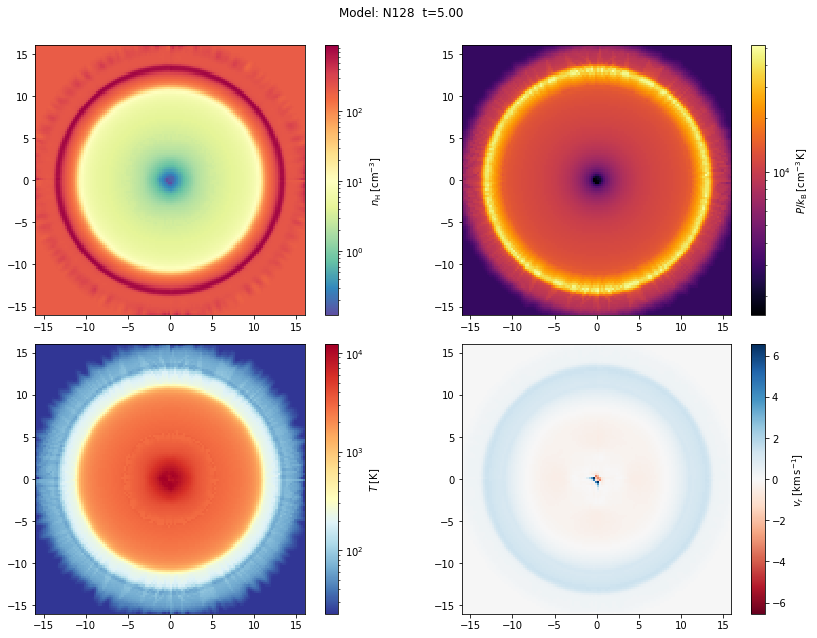

In [10]:
s = sa.set_model('N128')
ds = s.load_vtk(s.nums[-1])
fields = ['nH','pok','T','vr']
d = ds.get_slice('z', fields)
dfi = d.dfi

fig, axes = plt.subplots(2, 2, figsize=(12,9))
axes = axes.flatten()
for i, f in enumerate(fields):
    if f != 'vr':
        norm = LogNorm()
    else:
        norm = Normalize()
    d[f].plot.imshow(ax=axes[i], norm=norm, add_colorbar=True,
                     cmap=dfi[f]['cmap'], add_labels=False,
                     cbar_kwargs=dict(label=dfi[f]['label']))

for ax in axes:
    ax.set_aspect('equal')

plt.suptitle('Model: {:s}'.format(sa.model) + \
             r'  t={:.2f}'.format(d.domain['time']))
plt.tight_layout()
plt.subplots_adjust(top=0.92)

### Plot multple snapshots

In [11]:
def plt_snapshot(s, num, savdir=None, savfig=False):
    dfi = s.dfi
    ds = s.load_vtk(num)
    fields = ['nH','pok','T','vr']
    vminmax = dict(nH=(1e-3,1e3),
                   pok=(1e2,1e5),
                   T=(1e1,1e6),
                   vr=(0, 20))
    nf = len(fields)
    d = ds.get_slice('z', fields)
    fig, axes = plt.subplots(2, 2, figsize=(12,9))
    axes = axes.flatten()
    
    for i, f in enumerate(fields):
        if f != 'vr':
            norm = LogNorm(*vminmax[f])
        else:
            norm = Normalize(*vminmax[f])

        d[f].plot.imshow(ax=axes[i], norm=norm, add_colorbar=True,
                 cmap=dfi[f]['cmap'], add_labels=False,
                 cbar_kwargs=dict(label=dfi[f]['label']))
        axes[i].set_aspect('equal')
    plt.suptitle(f'Model: {s.basename}' + '  t={0:.2f}'.format(ds.domain['time']))
    
    if savfig:
        if savdir is None:
            savdir = osp.join('/tigress/jk11/figures/FEEDBACK-TEST', s.basename)
        if not osp.exists(savdir):
            os.makedirs(savdir)
        
        plt.savefig(osp.join(savdir, 'slice_{0:04d}.png'.format(num)), dpi=200)
        #print(osp.join(savdir, 'slice_{0:04d}.png'.format(num)))
    
    return ds, d

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

/home/jk11/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

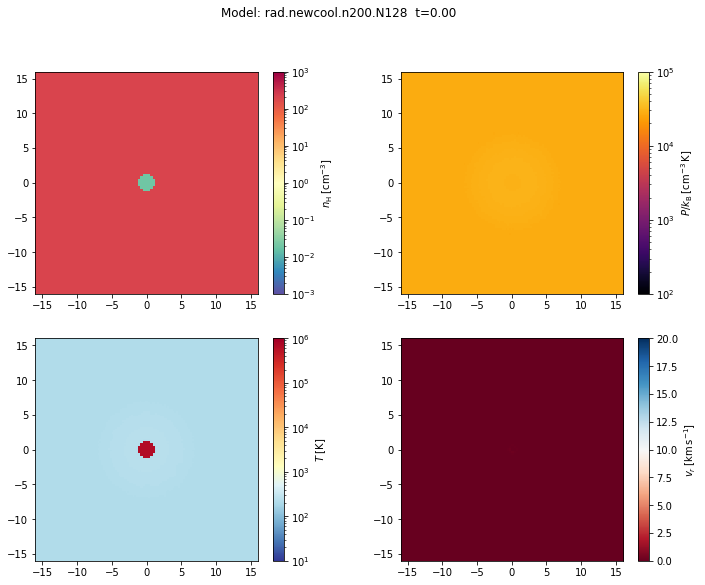

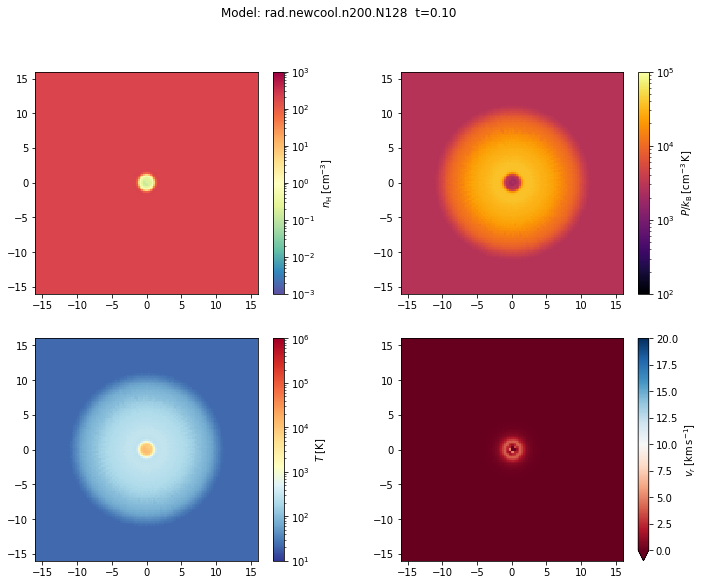

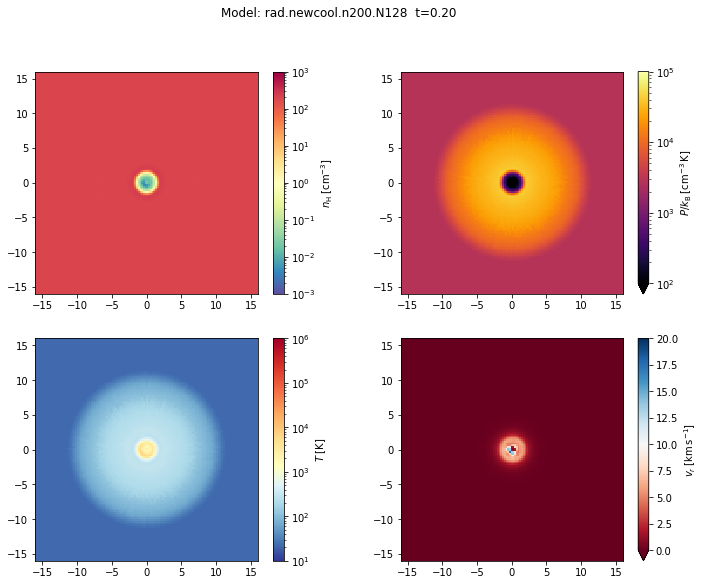

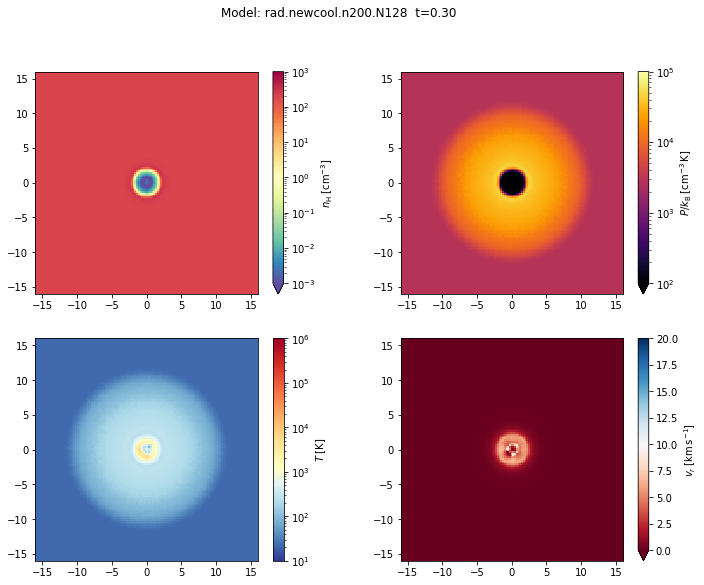

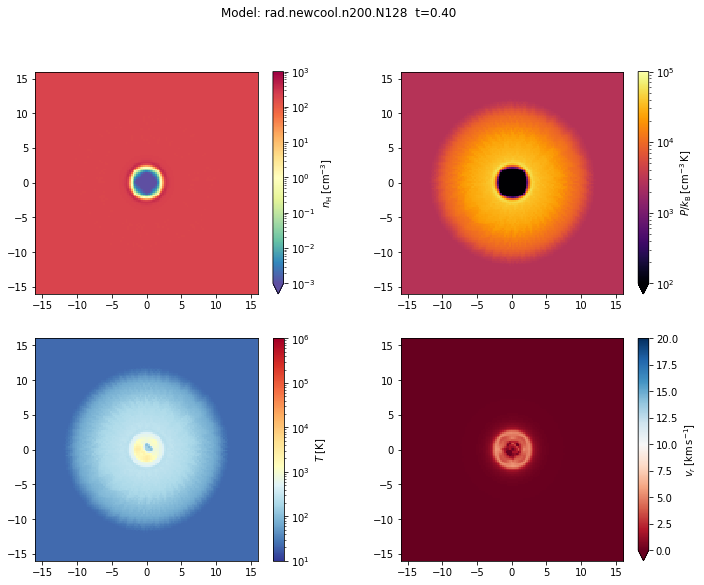

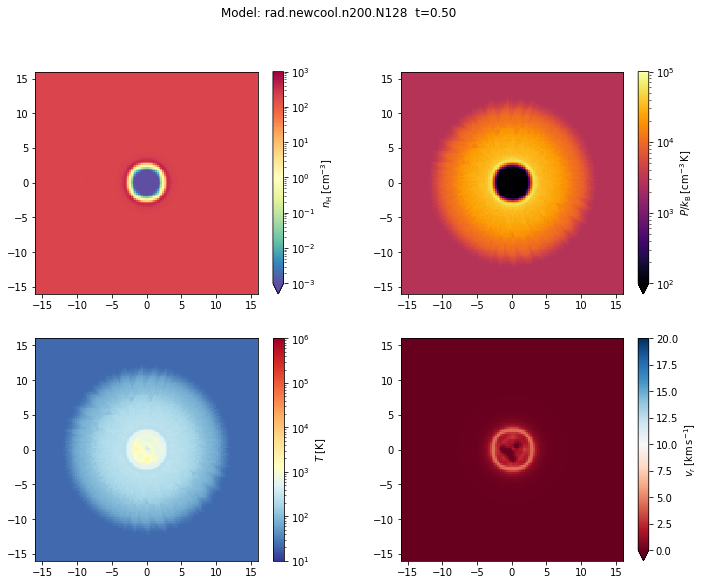

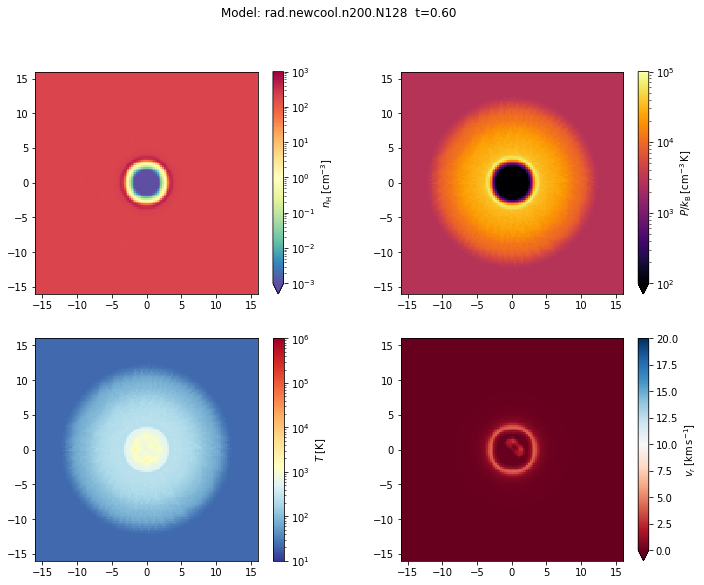

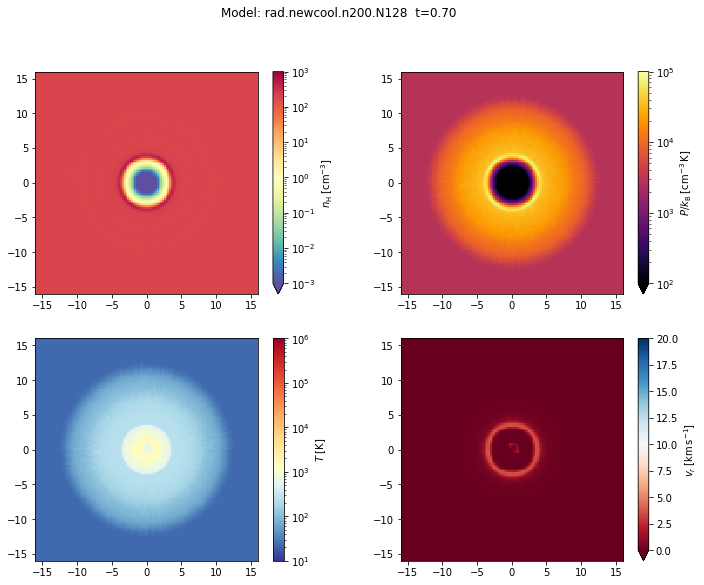

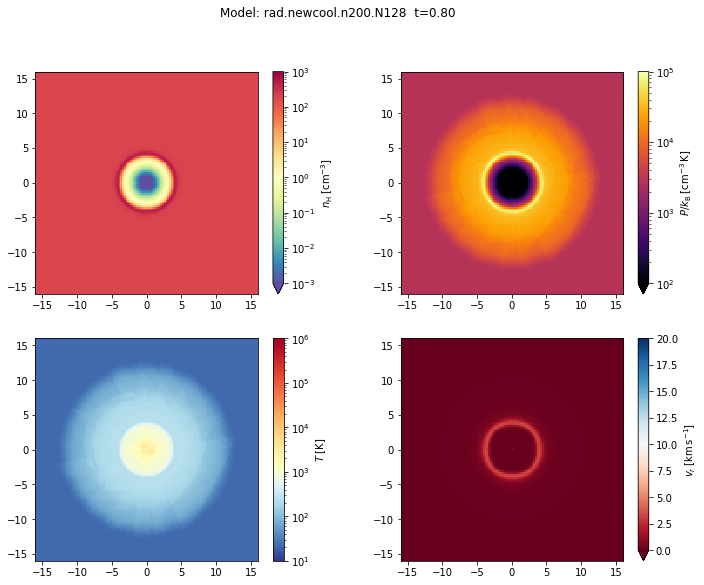

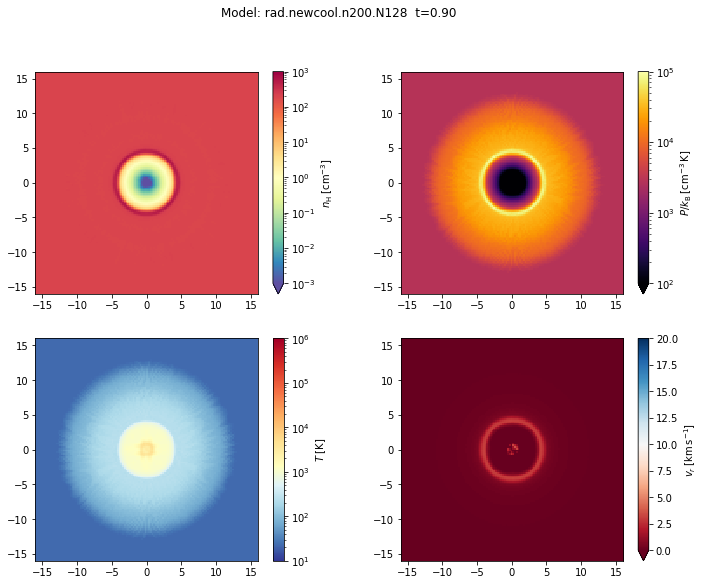

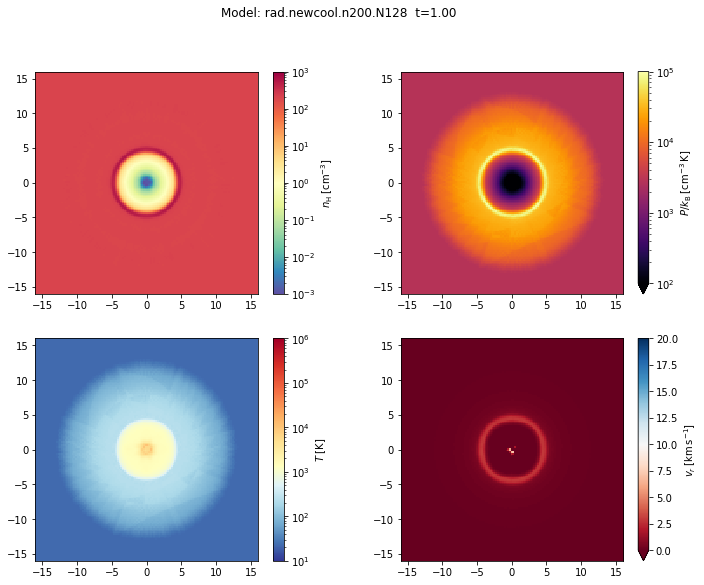

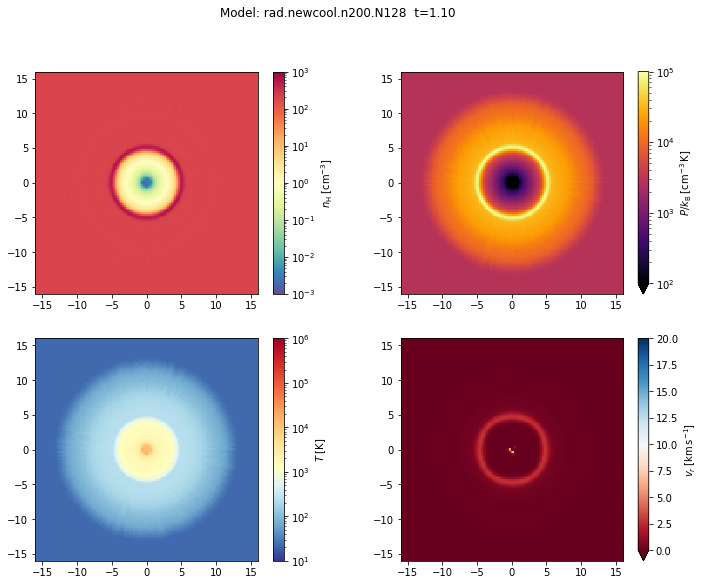

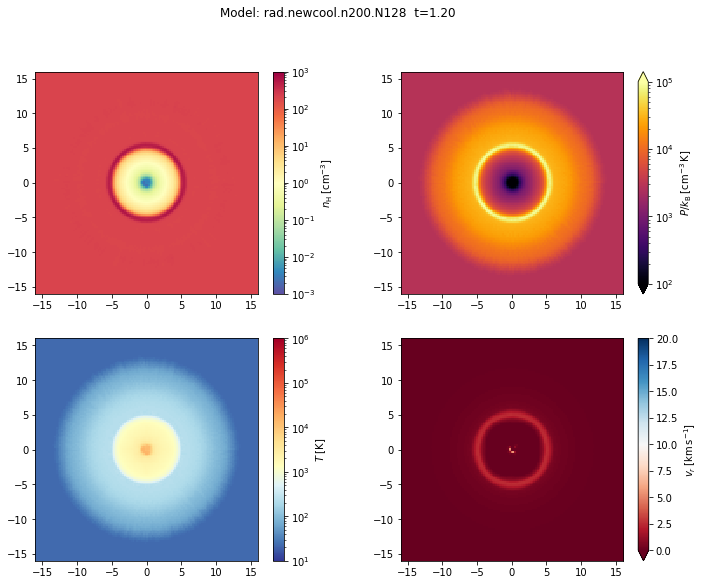

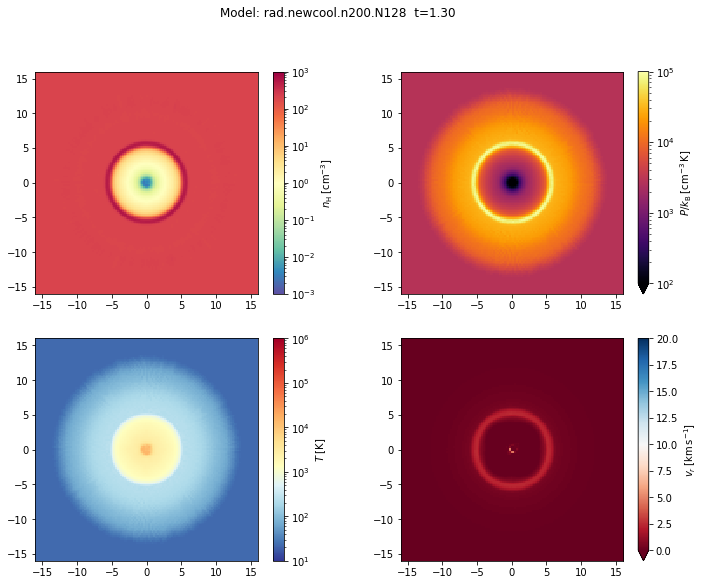

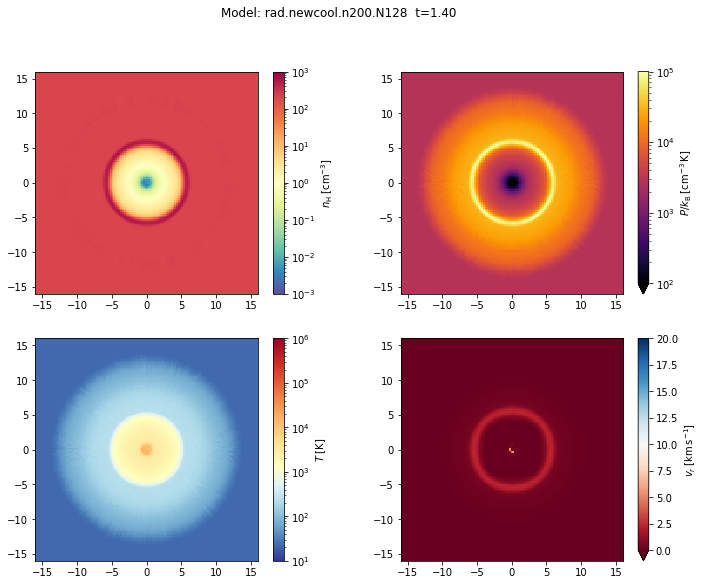

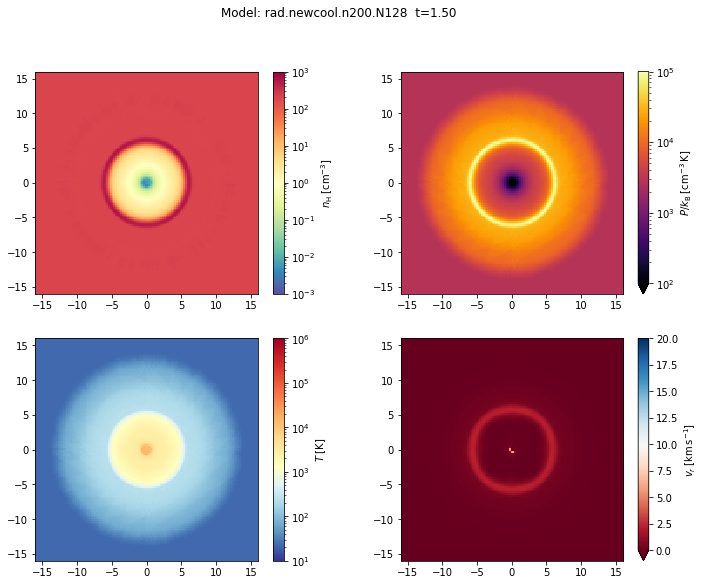

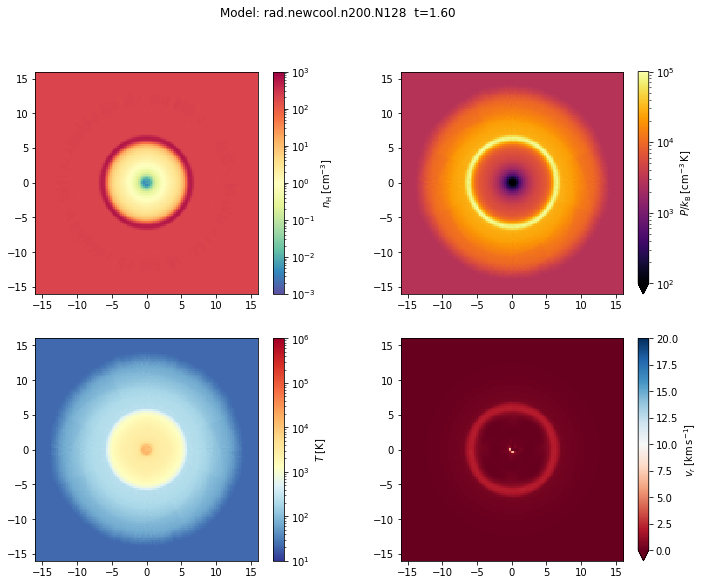

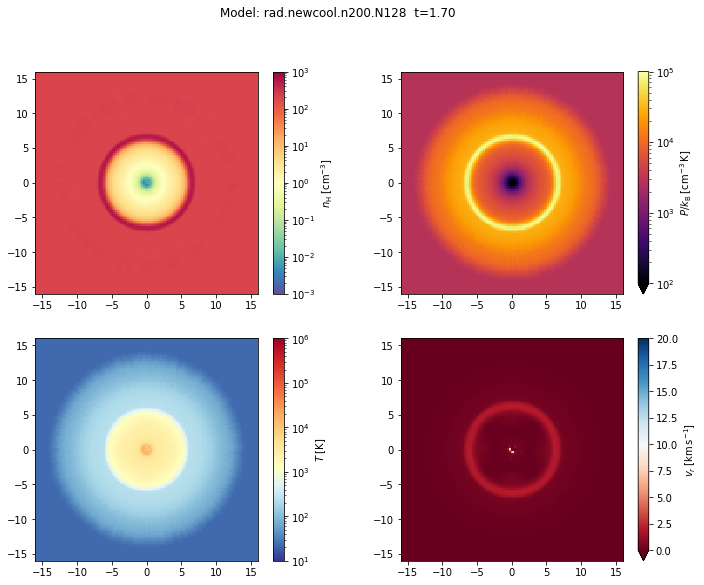

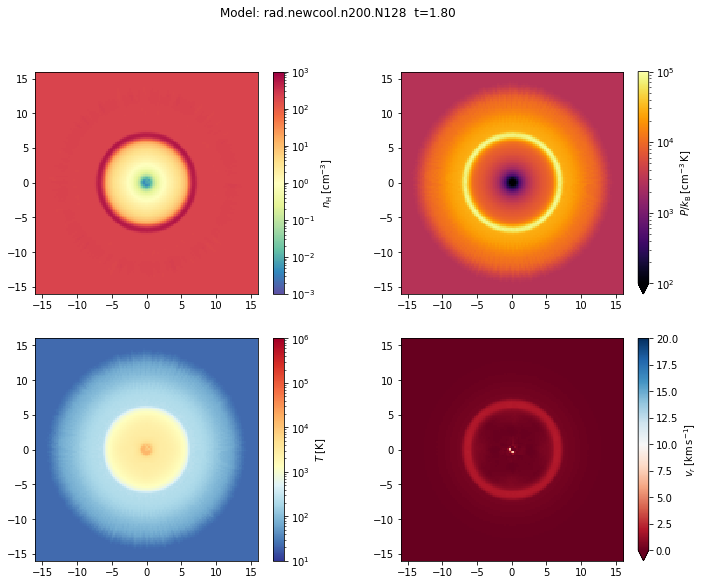

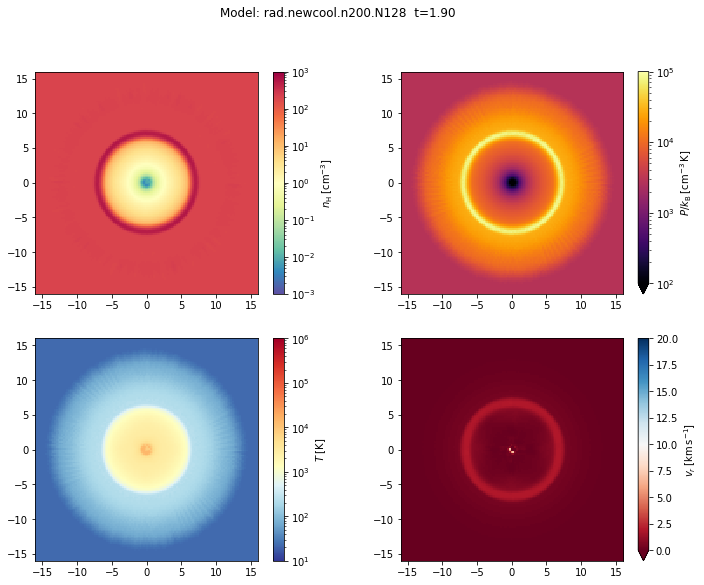

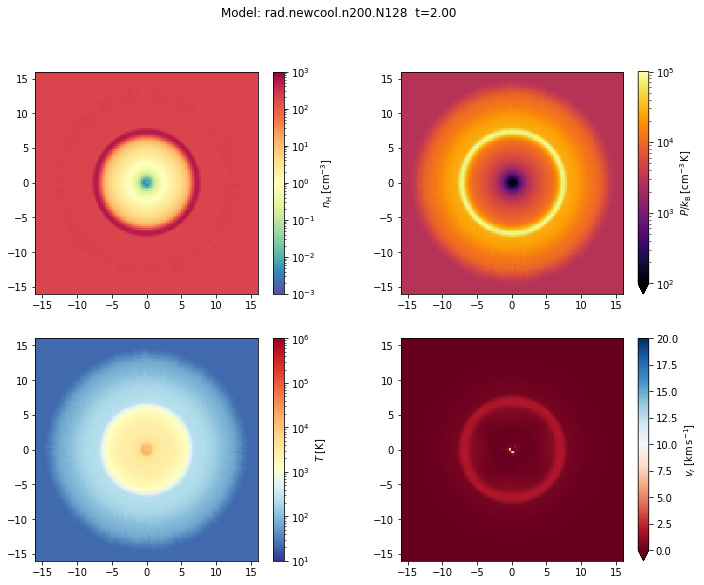

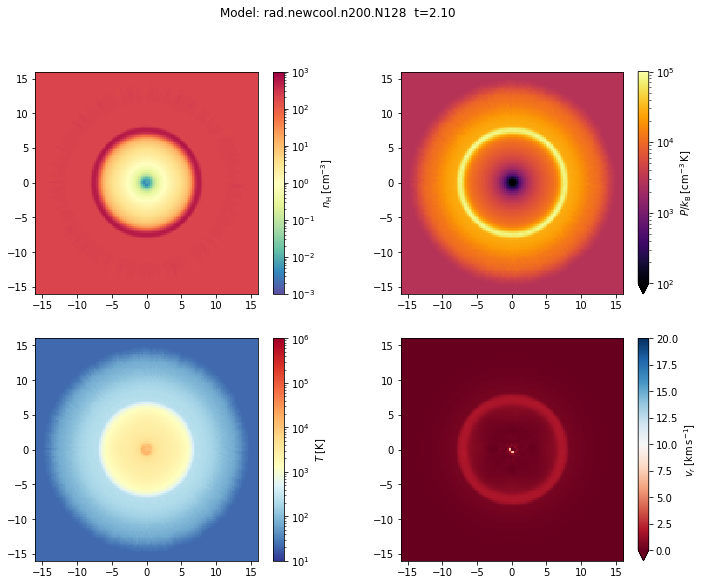

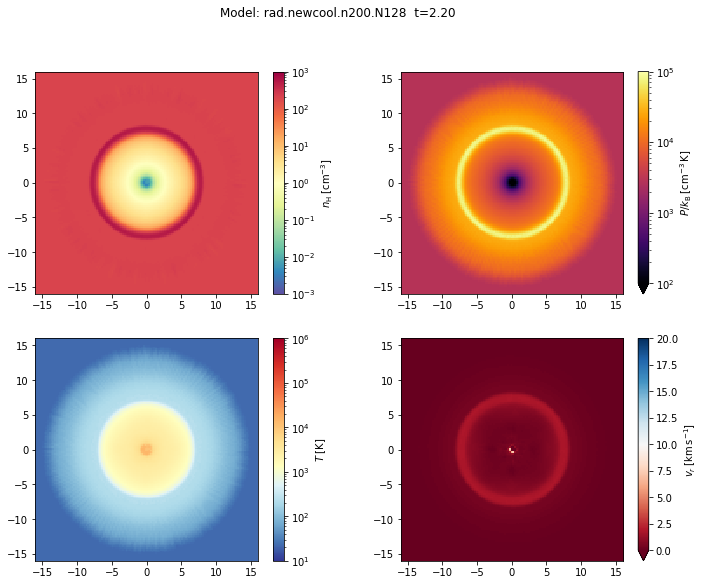

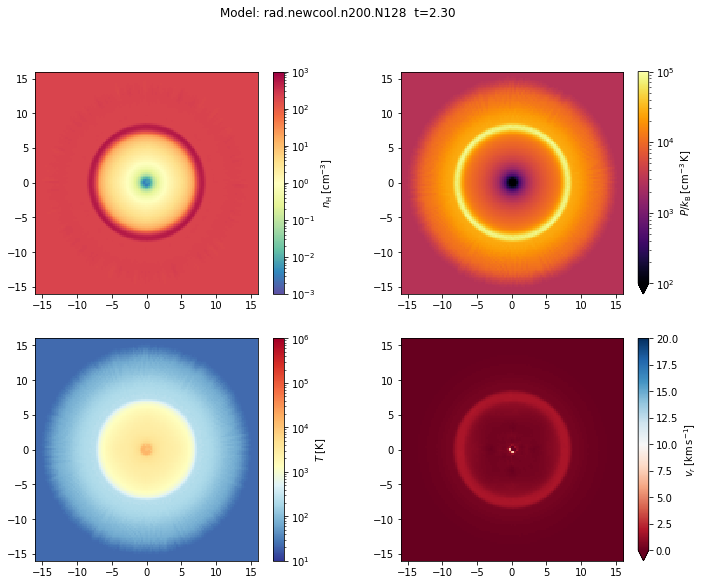

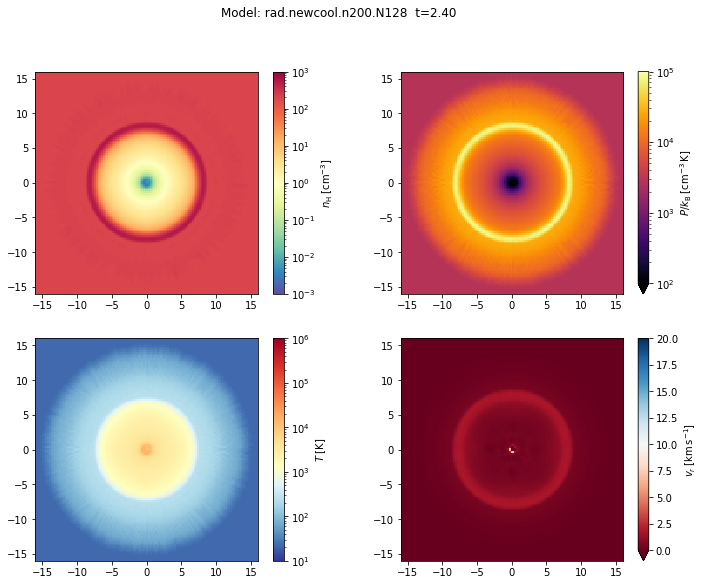

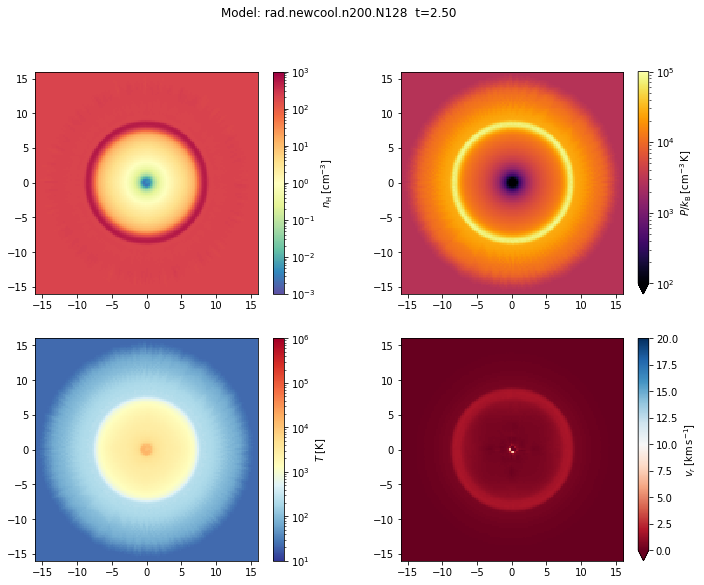

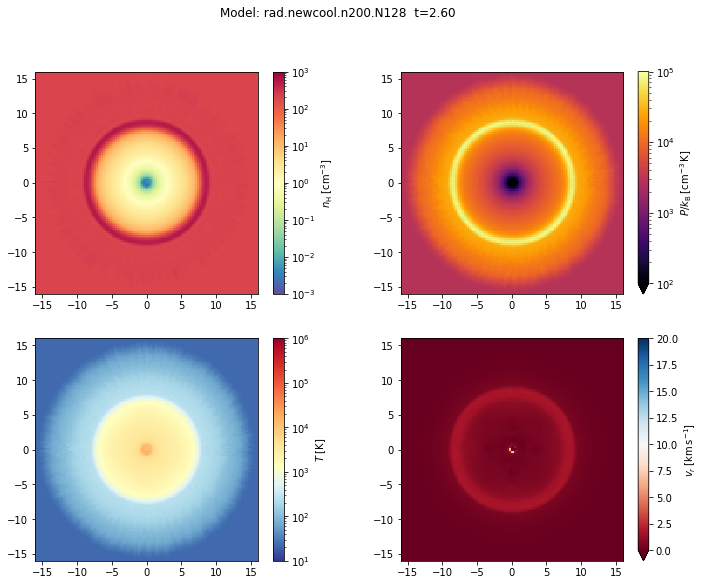

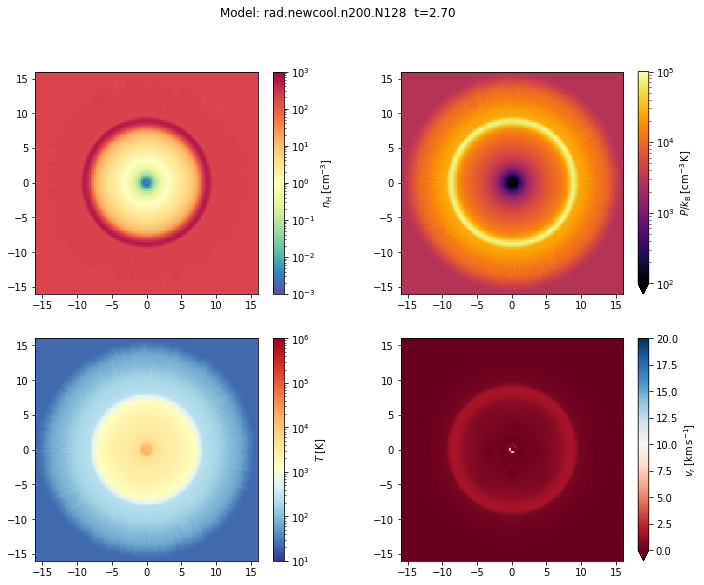

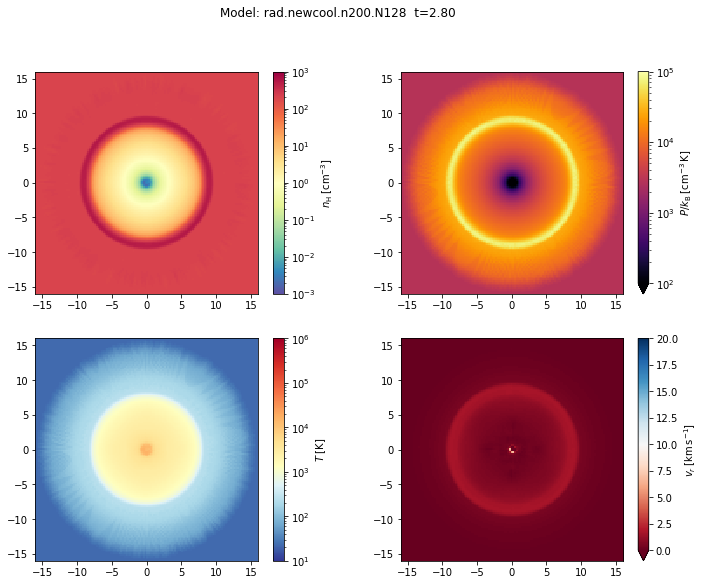

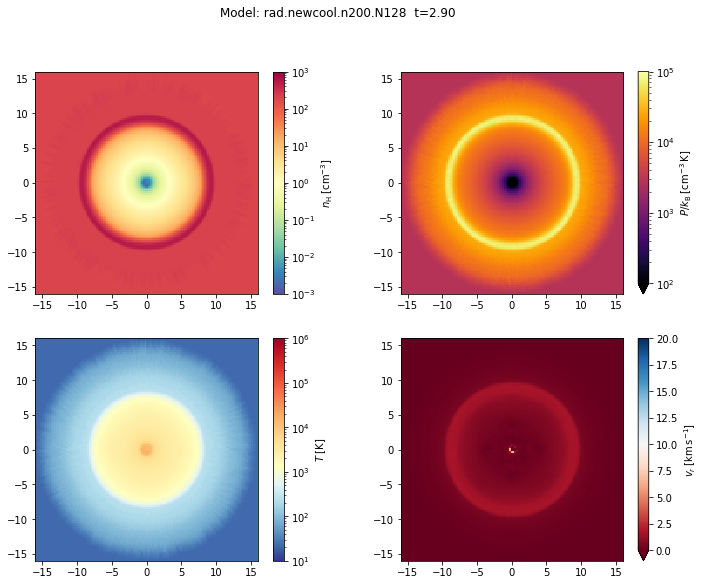

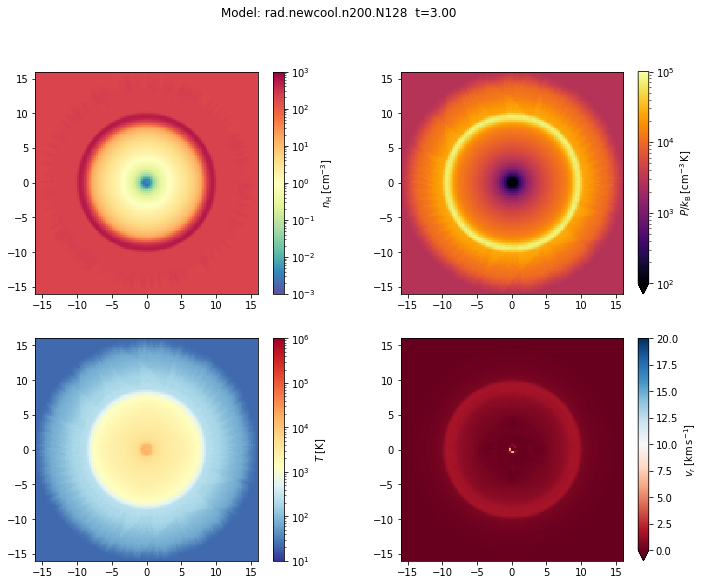

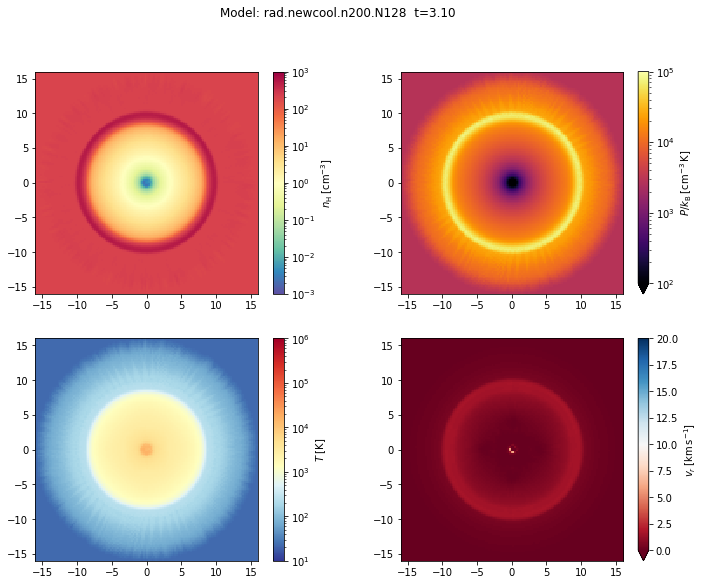

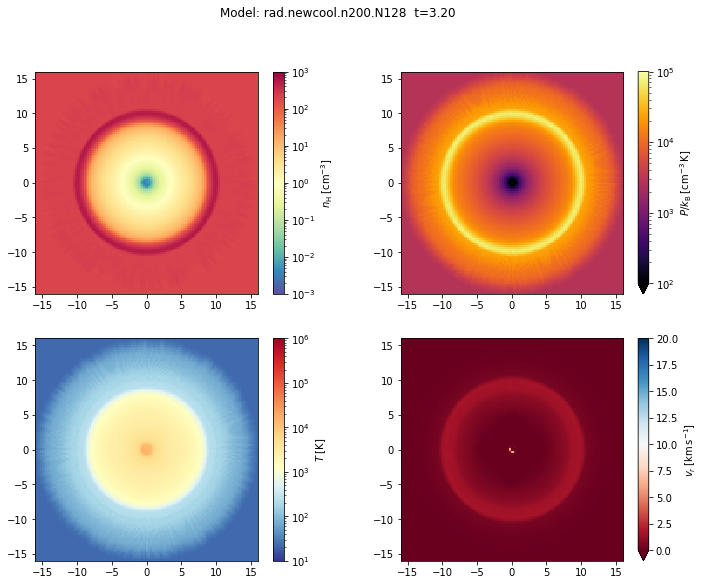

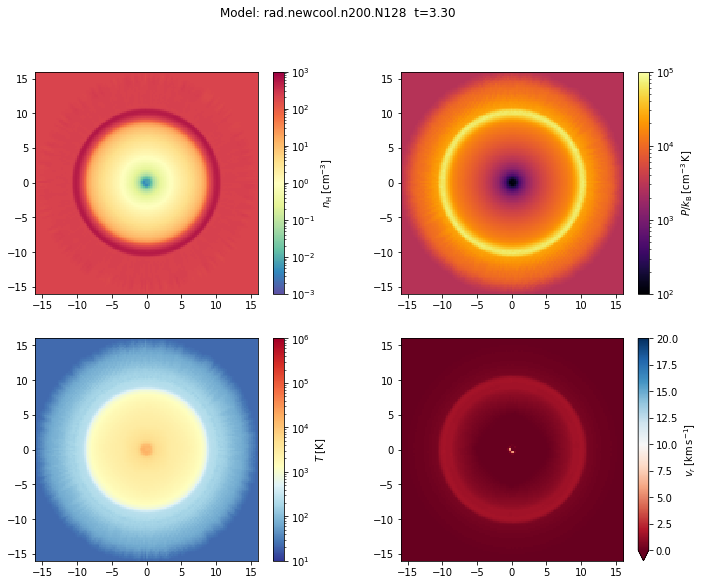

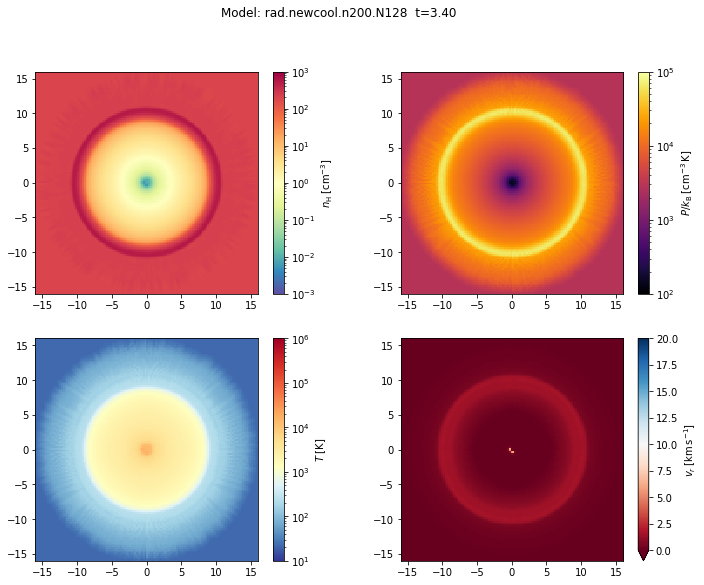

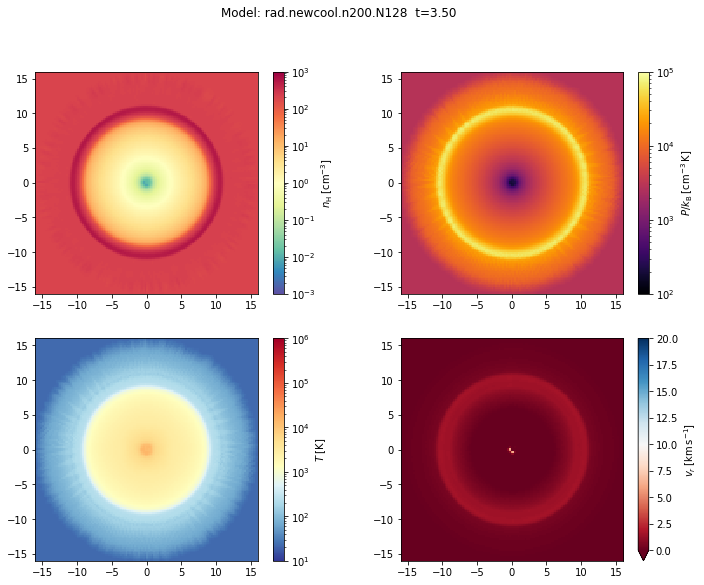

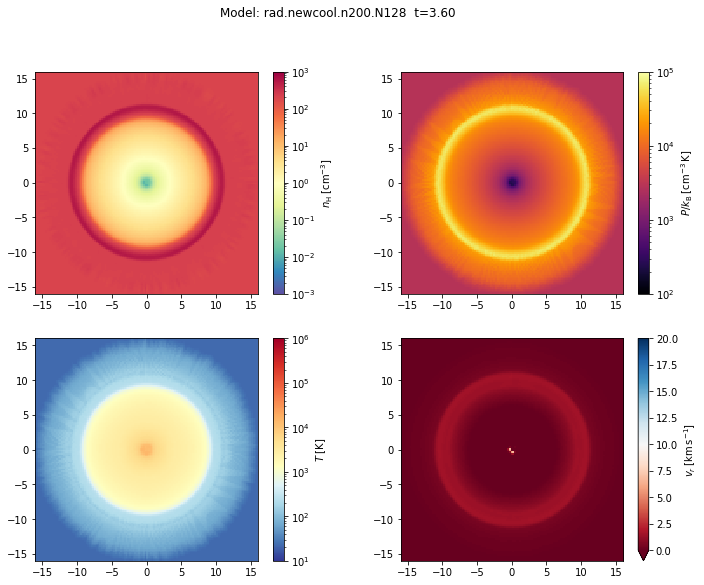

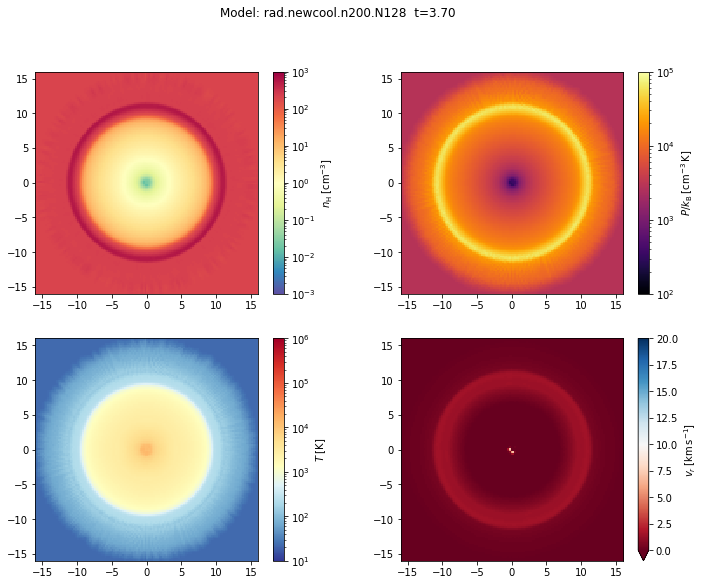

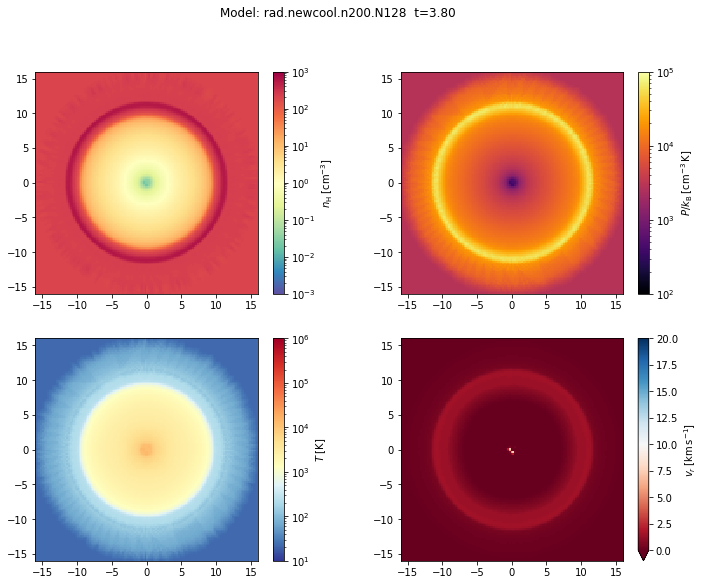

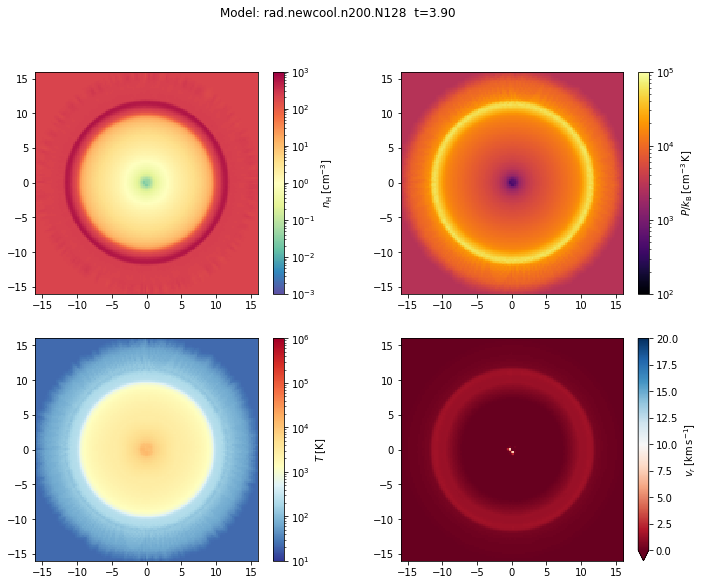

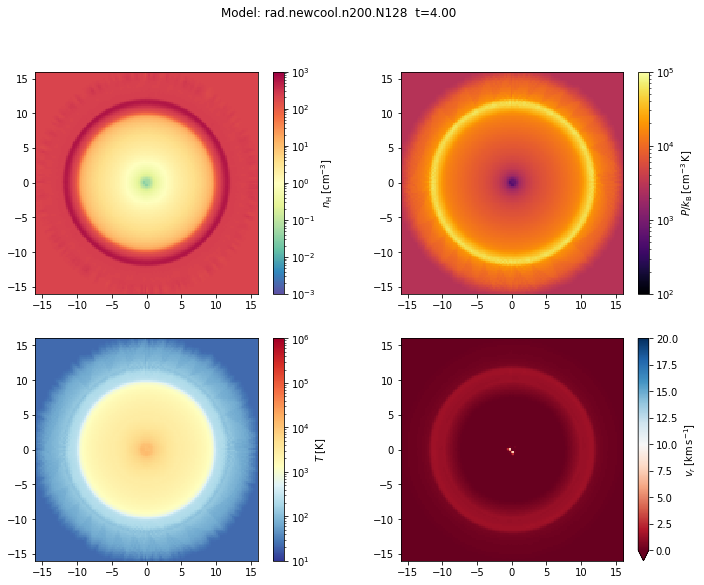

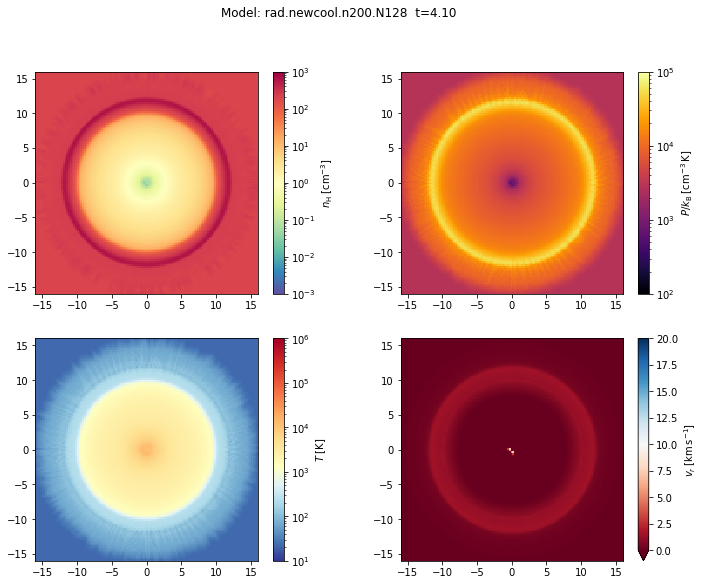

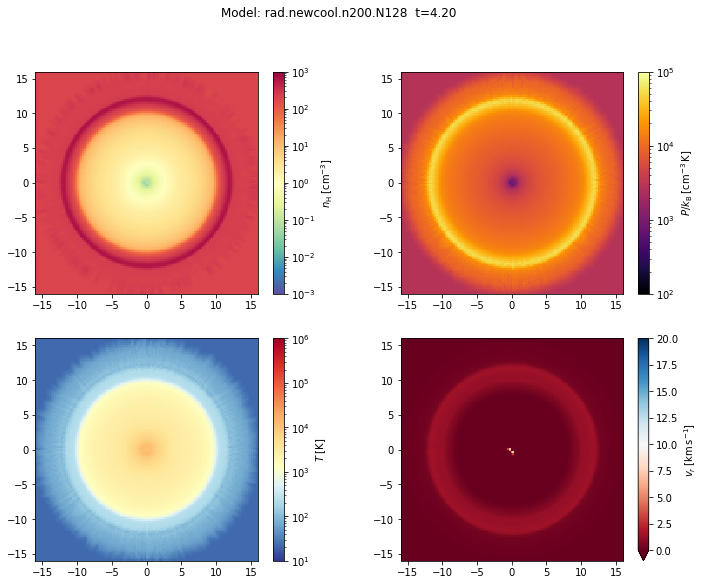

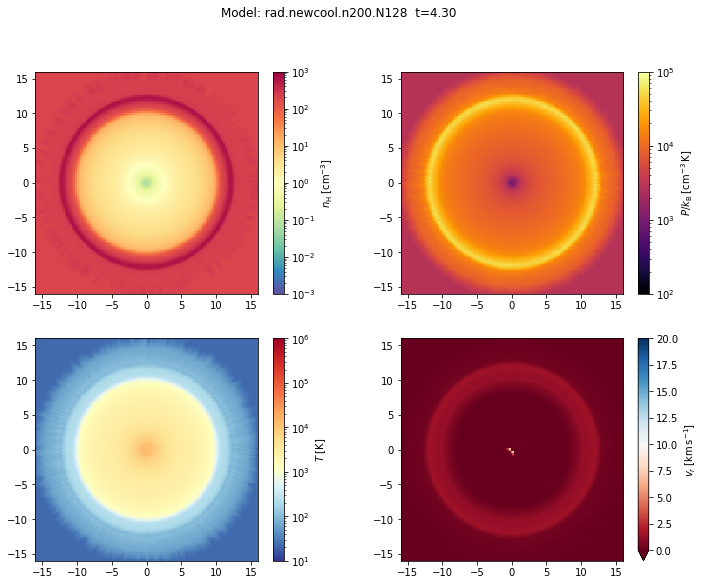

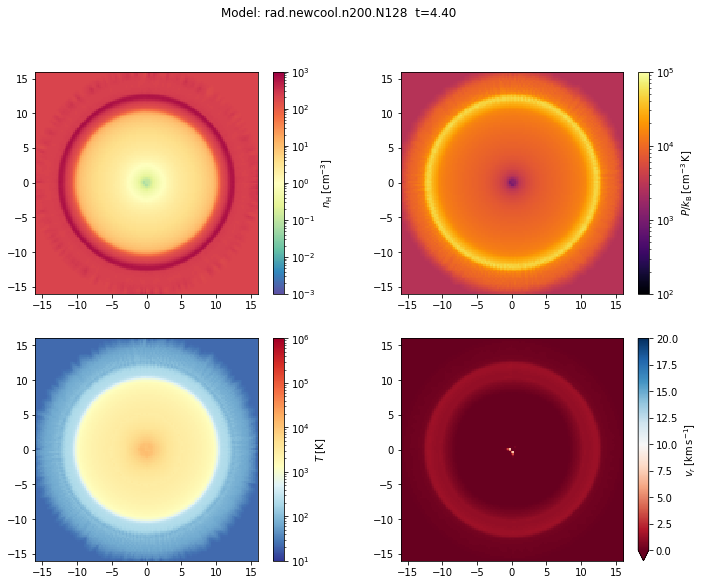

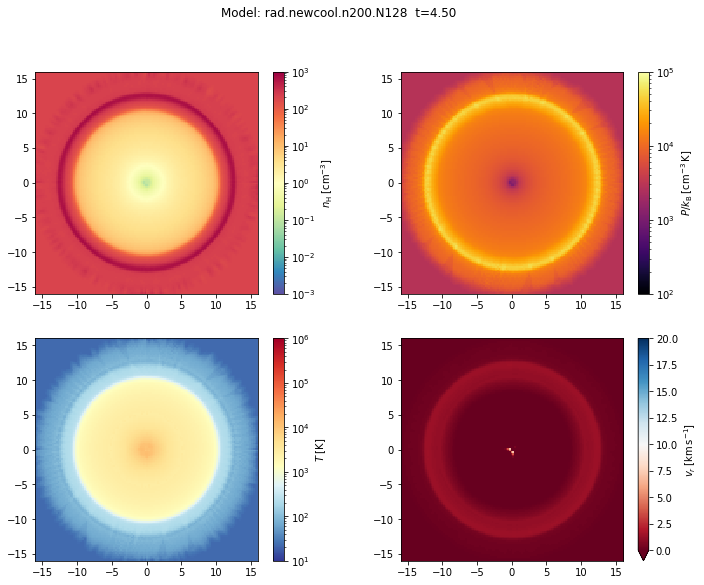

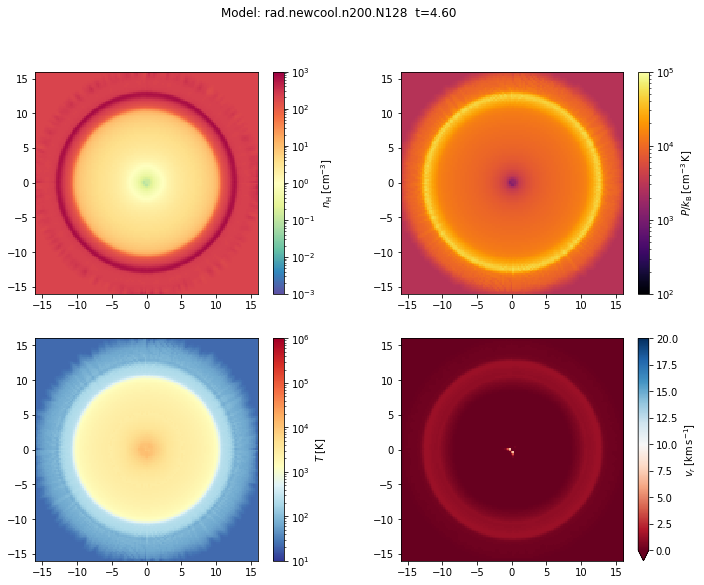

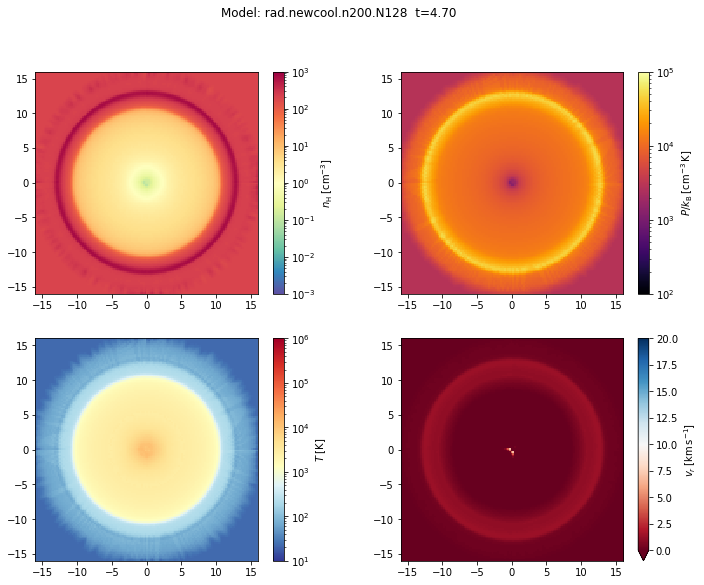

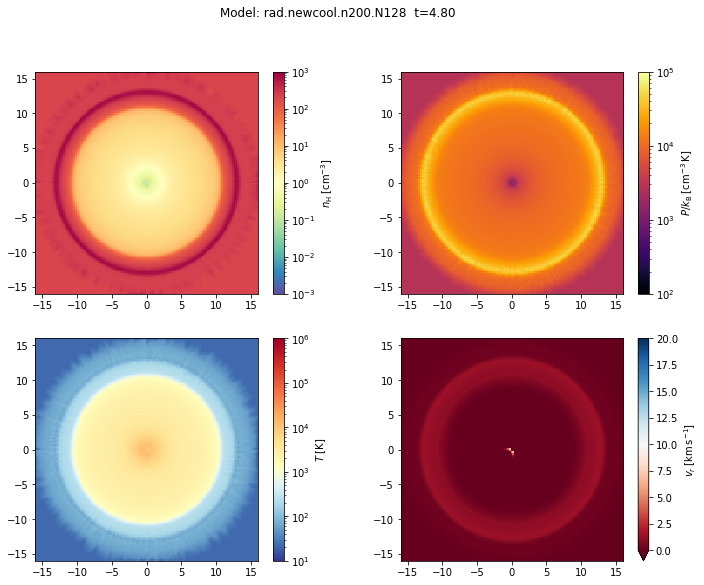

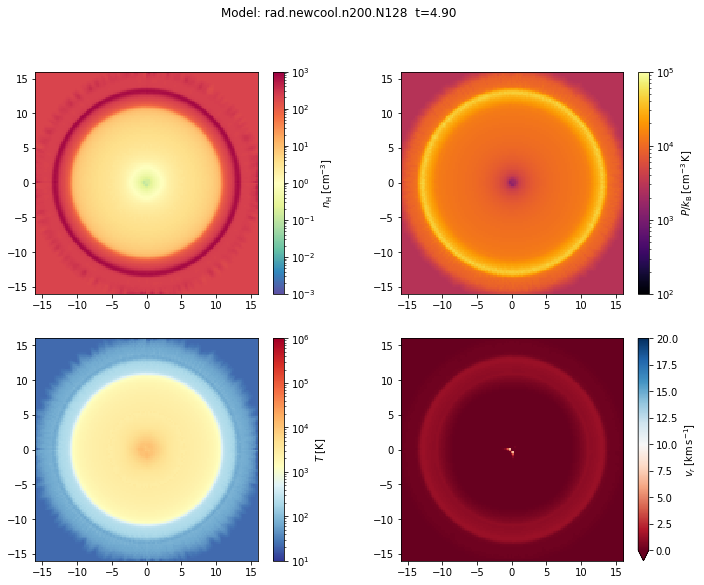

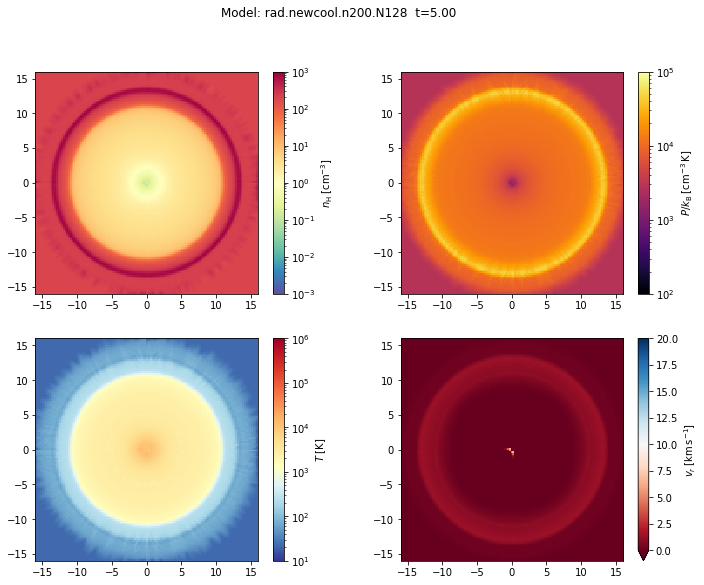

In [12]:
for num in s.nums:
    print(num, end=' ')
    ds, d = plt_snapshot(s, num, savfig=True);
    break

### Make and display movie

In [15]:
help(pa.make_movie)

Help on function make_movie in module pyathena.plt_tools.make_movie:

make_movie(fname_glob, fname_out, fps_in=15, fps_out=15)
    Create a mp4 movie from files matching a glob pattern 
    
    Parameters
    ----------
    fname_glob : string (glob)
        Glob pattern including wildcard
    fname_out : string
        Name of mp4 output file
    fps_in : int
        Frames per second for input 
    fps_output : int
        Frames per second for output
    
    Example
    -------
    To force the frame rate of the input file (valid for raw formats only) to 1
    fps and the frame rate of the output file to 24 fps
    
    >>> make_movie('a.????.png', 'a.mp4', fps_in=1, fps_out=24)



In [20]:
savdir = osp.join('/tigress/jk11/figures/FEEDBACK-TEST', s.basename)
fin = osp.join(savdir,'slice_????.png')
fout = osp.join(savdir,'slice.mp4')
# savdir
pa.make_movie(fin, fout, fps_in=10, fps_out=10)

[make_movie]: ffmpeg command:
ffmpeg -y -r 10 -f image2 -pattern_type glob -i /tigress/jk11/figures/FEEDBACK-TEST/rad.newcool.n200.N128/slice_????.png -r 10 -pix_fmt yuv420p -vcodec libx264 -vf scale=trunc(iw/2)*2:trunc(ih/2)*2 -f mp4 /tigress/jk11/figures/FEEDBACK-TEST/rad.newcool.n200.N128/slice.mp4
[make_movie]: Successful execution.
[make_movie]: Movie:
/tigress/jk11/figures/FEEDBACK-TEST/rad.newcool.n200.N128/slice.mp4


In [21]:
pa.display_movie(fout)